# Introduction

時系列データの異常検知を行います。

時系列データの異常検知の手法はこちらのスライドに記載しました。

今回はもっともシンプルなARモデルによる異常検知を行います。


# 各種ライブラリの取得



In [ ]:
import numpy as np
import pylab
from pandas import read_html
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html

In [ ]:
wave_data = read_html('https://github.com/jamesrobertlloyd/gpss-research/blob/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=0, )

(499,)


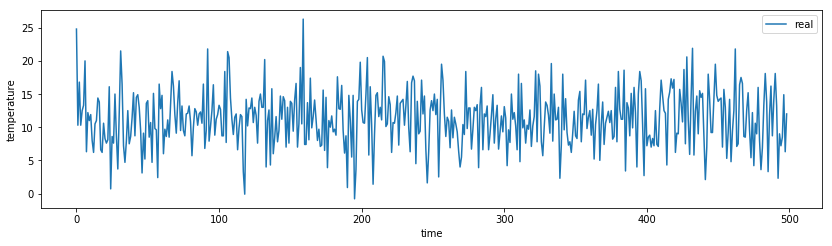

In [30]:
X_orig = wave_data[0].values[:, :, ]
X_orig = np.array([x[2] for x in X_orig])
print(X_orig.shape)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_orig, label='real')
pylab.legend(loc='upper right')
pylab.show()

# データの分割

- 学習データ
- 検証データ
- テストデータ

In [31]:
X_train = X_orig[:300]
X_valid = X_orig[300:400]
X_test = X_orig[400:]

# 学習データ

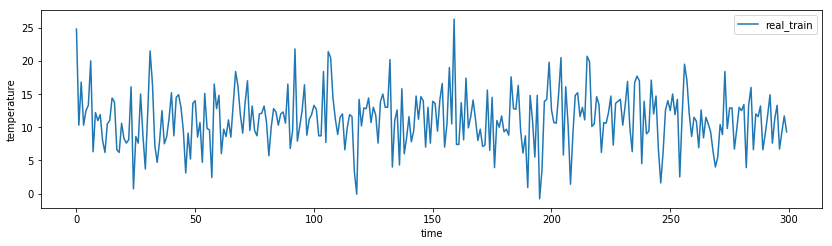

In [32]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_train, label='real_train')

pylab.legend(loc='upper right')
pylab.show()

# 検証データ

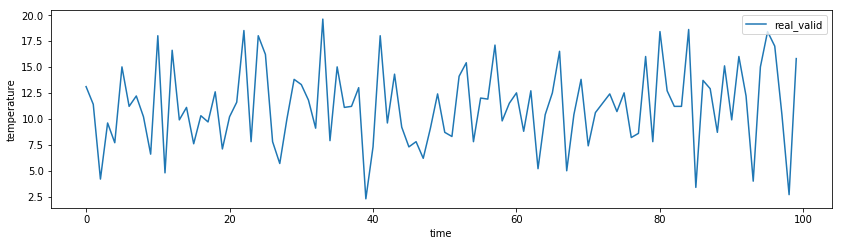

In [33]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_valid, label='real_valid')

pylab.legend(loc='upper right')
pylab.show()

# テストデータ

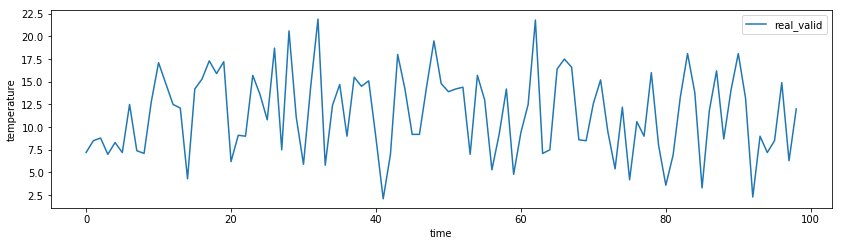

In [34]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_test, label='real_valid')

pylab.legend(loc='upper right')
pylab.show()

# Smooth process

- 移動平均によりスムージングして余分なノイズを除いています。下記の操作によってノイズを除去しています
 - windowの作成
 - 畳み込み処理

簡単な例を載せておきます。

In [35]:
# window の処理
window_len = 3
x = np.array([1, 2, 3, 4, 5])
s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
s

array([3, 2, 1, 2, 3, 4, 5, 4, 3])

In [36]:
w = np.ones(window_len, 'd')
print('window {}'.format(w))
    
y = np.convolve( w / w.sum(), s, mode='valid')
y

window [1. 1. 1.]


array([2.        , 1.66666667, 2.        , 3.        , 4.        ,
       4.33333333, 4.        ])

In [37]:
def smooth(x, window_len=11):

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    
    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), s, mode='valid')
    return y

# 学習データのスムージング

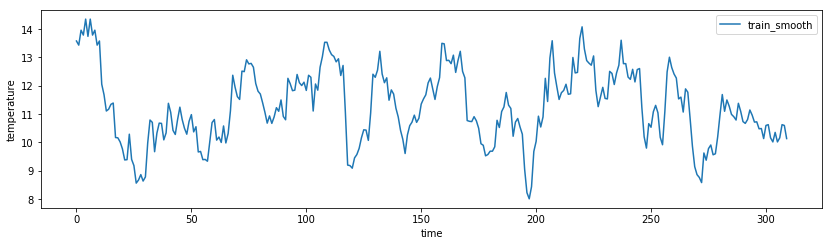

In [38]:
X_smooth_train = smooth(X_train)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_train, label='train_smooth')
pylab.legend(loc='upper right')
pylab.show()

# 検証データのスムージング

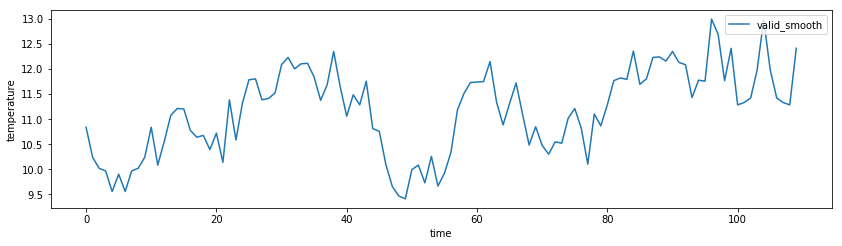

In [39]:
X_smooth_valid = smooth(X_valid)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_valid, label='valid_smooth')
pylab.legend(loc='upper right')
pylab.show()

# テストデータのスムージング

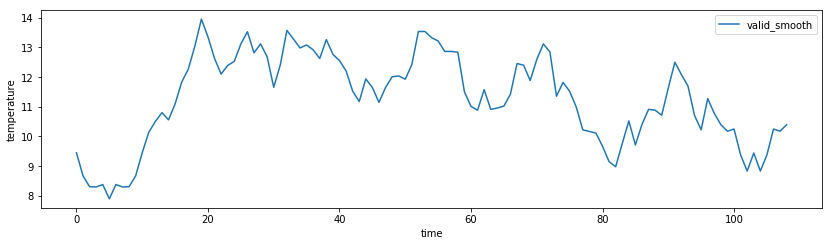

In [40]:
X_smooth_test = smooth(X_test)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_test, label='valid_smooth')
pylab.legend(loc='upper right')
pylab.show()

# 異常データの作成

本来は元データに異常を付与する必要があるが分かりづらいのでスムージングしたデータに異常を付与

- スパイク型
- 波形変化
- レベルシフト

# スパイク型

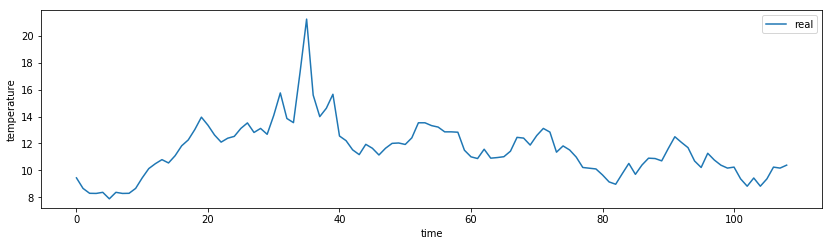

In [41]:
series = [np.abs(gauss(0.0, 5.0)) for i in range(10)]
spike_X = X_smooth_test.copy() 
spike_X[30:40] = spike_X[30:40] + series

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(spike_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# 波形変化

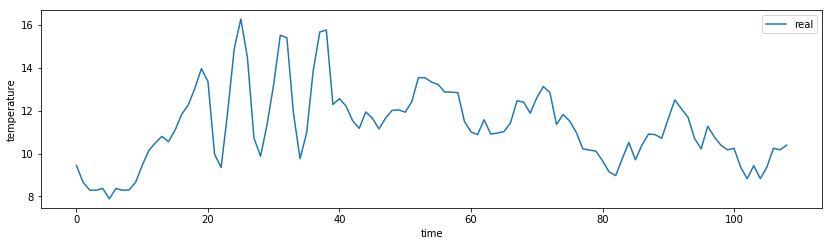

In [42]:
change_value = np.arange(0, 20, 1)
change_X = X_smooth_test.copy() 
change_X[20:40] = change_X[20:40] - (0.25 * change_X[20:40] * np.sin(change_value))

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(change_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# レベルシフト

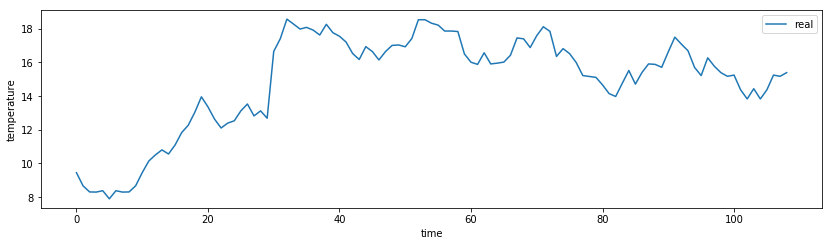

In [43]:
shift_X = X_smooth_test.copy() 
shift_X[30:] = shift_X[30:] + 5.0

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(shift_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# ARモデルの学習

- Lag: windowの幅
- Coefficients: 学習後のパラメータ

In [44]:
def train_autoregression(train_data):
    # train autoregression
    model = AR(train_data)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    print('aic {}'.format(model_fit.aic))
    return model_fit

# データの予測

- history: 過去データを保存し予測に使用
- lag: 過去データの末尾のwindowサイズ分のデータを保持
- yhat: ARモデルの予測データ

In [45]:
def predict_autoregression(model, valid_data):
    window = model.k_ar
    coef = model.params
    
    history = valid_data[len(valid_data) - window:]
    history = [h for h in history]
    predictions = []

    for index, test in enumerate(valid_data):
        length = len(history)
        lag = [history[i] for i in range(length - window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d + 1] * lag[window - d - 1]
        obs = test
        predictions.append(yhat)
        history.append(obs)

    return predictions

Lag: 16
Coefficients: [ 1.29306375  1.03116025 -0.12766218  0.024919    0.03051083  0.02435715
 -0.08120145  0.03283653  0.08590711 -0.1031092  -0.08189476 -0.40351871
  0.58322877 -0.12956225 -0.04407285  0.14704034 -0.1051522 ]
aic -1.4741983570220478


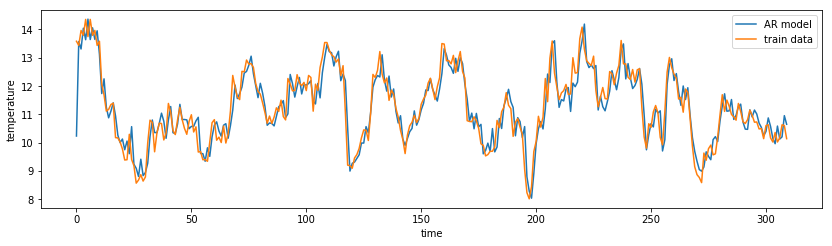

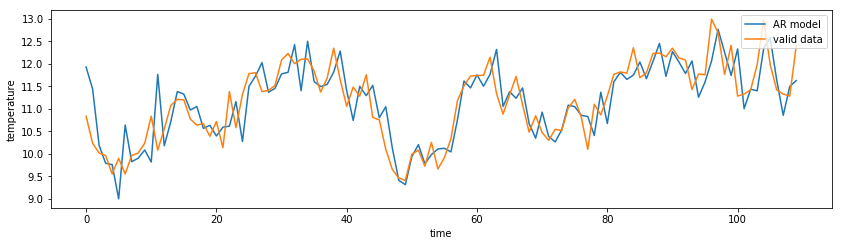

In [46]:
model = train_autoregression(X_smooth_train)

X_smooth_train = X_smooth_train
predictions = predict_autoregression(model, X_smooth_train)

X_smooth_valid = X_smooth_valid
predictions_valid = predict_autoregression(model, X_smooth_valid)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(predictions, label='AR model')
pylab.plot(X_smooth_train, label='train data')
pylab.legend(loc='upper right')
pylab.show()

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(predictions_valid, label='AR model')
pylab.plot(X_smooth_valid, label='valid data')
pylab.legend(loc='upper right')
pylab.show()

# Anomaly Score

異常度の計算部分
- 初回の計算は分散が不定なので1で固定
- 学習データで導出した分散を使用

In [47]:
def calculate_mse(value, predict_value, variance=1.0):
    mse_value = [(v - p_v)**2 / variance for v, p_v in zip(value, predict_value)]
    return mse_value


mse_value_org = calculate_mse(X_smooth_train, predictions)
mse_value_variance = np.var(mse_value_org)
mse_value = calculate_mse(X_smooth_train, predictions, mse_value_variance)

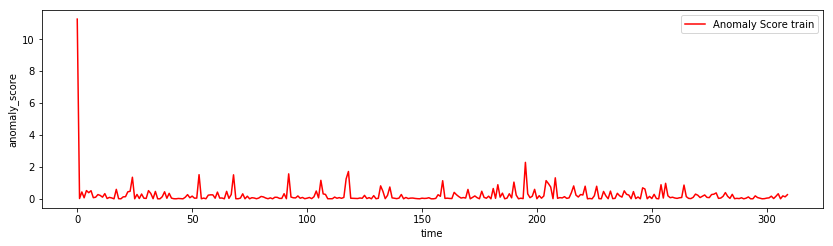

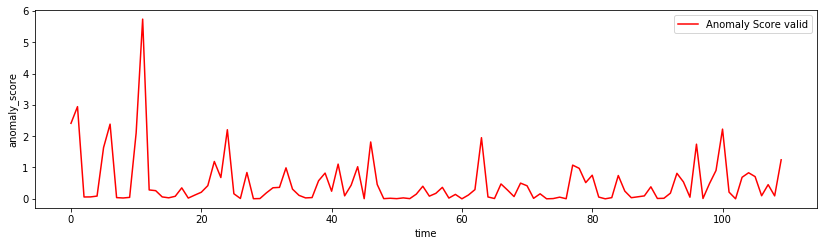

threshold value 5.737344444572401


In [48]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot(mse_value_org, "r", label='Anomaly Score train')
pylab.legend(loc='upper right')
pylab.show()

mse_value_valid = calculate_mse(X_smooth_valid, predictions_valid, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot(mse_value_valid, "r", label='Anomaly Score valid')
pylab.legend(loc='upper right')
pylab.show()

threshold = np.max(mse_value_valid)
print("threshold value {}".format(threshold))

# Anomaly Detection

# Normal Data Case

正常データは異常として検知しないかを確認

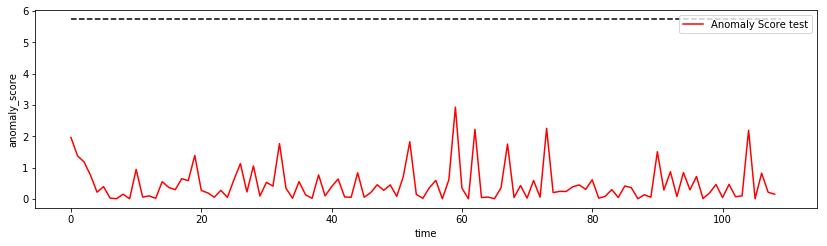

In [49]:
X_smooth_test = X_smooth_test
predictions_test = predict_autoregression(model, X_smooth_test)

mse_value_test_normal = calculate_mse(X_smooth_test, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test_normal, "r", label='Anomaly Score test')
pylab.legend(loc='upper right')
pylab.show()

# Spike Wave Case

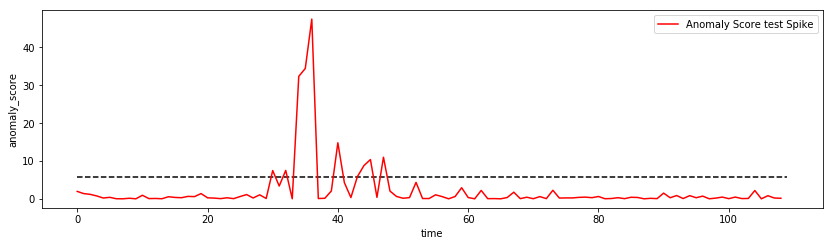

In [50]:
spike_X = spike_X
predictions_test = predict_autoregression(model, spike_X)

mse_value_test_spike = calculate_mse(spike_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test_spike, "r", label='Anomaly Score test Spike')
pylab.legend(loc='upper right')
pylab.show()

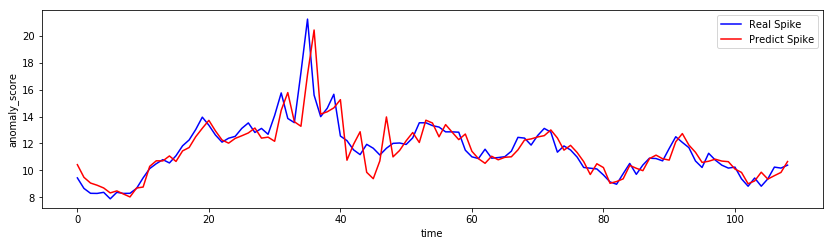

In [51]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot(spike_X, "b", label='Real Spike')
pylab.plot(predictions_test, "r", label='Predict Spike')
pylab.legend(loc='upper right')
pylab.show()

# Change Wave Case

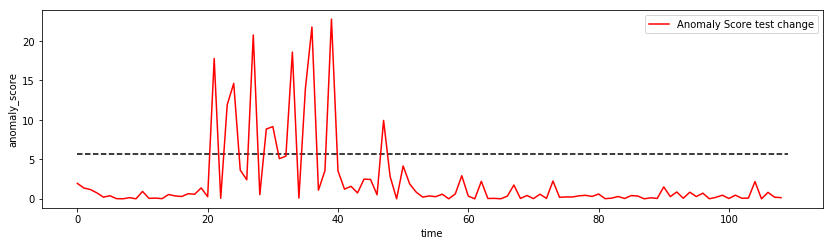

In [52]:
change_X = change_X
predictions_test = predict_autoregression(model, change_X)

mse_value_test_change_wave = calculate_mse(change_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test_change_wave, "r", label='Anomaly Score test change')
pylab.legend(loc='upper right')
pylab.show()

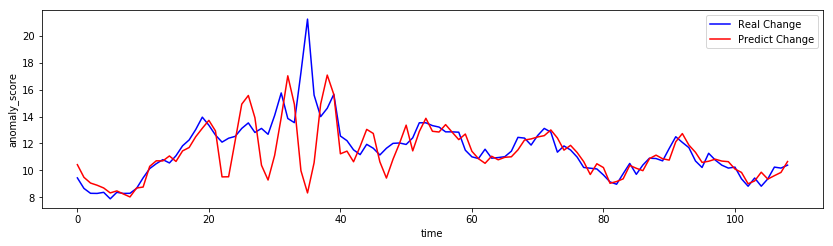

In [53]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot(spike_X, "b", label='Real Change')
pylab.plot(predictions_test, "r", label='Predict Change')
pylab.legend(loc='upper right')
pylab.show()

# Shift Wave Case

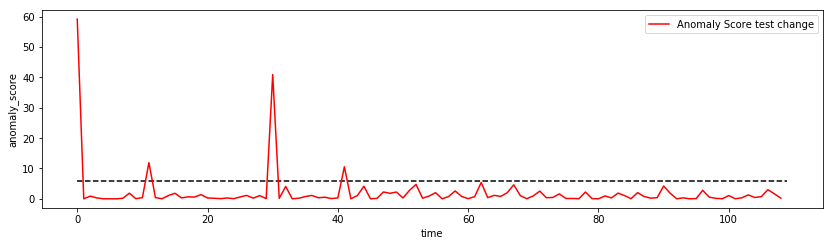

In [54]:
shift_X = shift_X
predictions_test = predict_autoregression(model, shift_X)

mse_value_test_shift = calculate_mse(shift_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test_shift, "r", label='Anomaly Score test change')
pylab.legend(loc='upper right')
pylab.show()

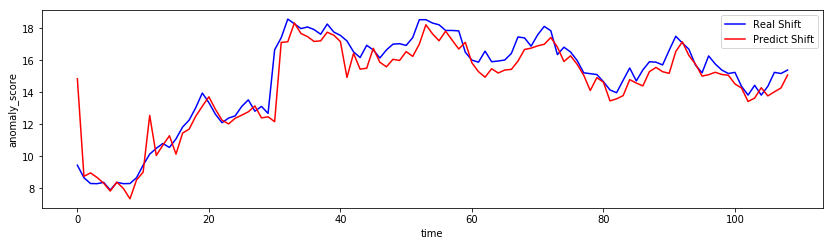

In [55]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('anomaly_score')
pylab.plot(shift_X, "b", label='Real Shift')
pylab.plot(predictions_test, "r", label='Predict Shift')
pylab.legend(loc='upper right')
pylab.show()

# ROC カーブを記述し実際の性能を確認

- 異常の部分を0、正常部分を1の配列を用意
- rocに渡すスコアの引数は正常である確信度なので異常度の場合は逆数にする必要がある

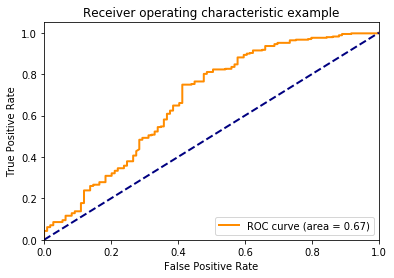

In [59]:
mse_value_test_normal = np.array(mse_value_test_normal)
mse_value_test_spike = np.array(mse_value_test_spike)
mse_value_test_change_wave = np.array(mse_value_test_change_wave)
mse_value_test_shift = np.array(mse_value_test_shift)

# Normal
answer_normal = np.ones(X_smooth_test.shape)

# Spike
answer_spike = np.ones(spike_X.shape)
answer_spike[30:40] = 0

# Change
answer_change = np.ones(change_X.shape)
answer_change[20:40] = 0

# Shift
answer_shift = np.ones(shift_X.shape)
answer_shift[30:] = 0

anomaly_score = np.append(mse_value_test_normal, 
                          mse_value_test_spike)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_change_wave)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_shift,
                         )

answer_array = np.append(answer_normal, answer_spike)
answer_array = np.append(answer_array, answer_change)
answer_array = np.append(answer_array, answer_shift)

fpr, tpr, _ = roc_curve(answer_array, 1.0 / anomaly_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# 発展課題

- 異常データを作成して検知できるか試して見ましょう
 - 非周期型はまだやっていないです
- ROCの性能が不十分なので上げるための方法を考えてみましょう